# House price prediction from Airbnb housing and socio-demographic indexes from New York City, 2017

* Brocco Mattia **|** 873058
* Piccolo Giulio **|** 874727

In [1]:
import dtale
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

import Data_cleaner as cle
%reload_ext autoreload
%autoreload 2

In [ ]:
#################### IDEAS
# From Block, Lot and Borough CREATE a map to locate each building

In [ ]:
### URL datasets
# https://www.kaggle.com/muonneutrino/new-york-city-census-data
# https://www.kaggle.com/new-york-city/nyc-property-sales#nyc-rolling-sales.csv

### Giulio
# filename = "/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_Airbnb_2017.csv"
# filename1 = "/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_house_price.csv"

### Mattia
# filename = "/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_Airbnb_2017.csv"
# filename1 = "/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_house_price.csv"

In [2]:
airbnb = pd.read_csv("/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_Airbnb_2017.csv",
                    low_memory = False)
house_price = pd.read_csv("/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_house_price.csv")
crashes = pd.read_csv("/Users/matti/Desktop/nypd-motor-vehicle-collisions.csv", low_memory = False)

## Data cleasing of NYC House Price dataset

To assess the proportion to cut off the mean to compute the trimmed mean, we performed this analysis and the graphic result shows how a good approximation can be made at the cutoff of:
* 0.011 for "land_square_feet"
* 0.08 for "gross_square_feet"

```python
# This study was performed during data cleaning operations of the abovementioned dataframe
x_var = np.arange(0, 0.5, 0.001)
y_var = np.array( [round(scipy.stats.trim_mean(df_price['land_square_feet'], x), 3) for x in x_var] )
z_soglia = [1650 for x in range(len(x_var))] # visual check for interception with y_var

plt.figure(figsize=(15,6))
plt.plot(y_var, linewidth = 5, color = "#A4063E")
plt.plot(z_soglia, linewidth = 2, color = "blue")

def find_nearest(array, value):
    """
    * idx is the position (index) of the value we are looking for,
    using the function armin to find the minimum value
    * then return the actual value found
    """
    idx = (np.abs(array - value)).argmin()
    return array[idx]

y_var_list = list(y_var)
x_var_list = list(x_var)

# Visualize the threshold for the truncated mean
print(  x_var_list[y_var_list.index(find_nearest(y_var, z_soglia[0]))]  )
```

## SERVE RESETTARE L'INDEX DI DF_PRICE

In [3]:
cleaner = cle.cleaners()
df_price = cleaner.house_price_cleaner(house_price)

df_price.ndim # get the dimension
df_price.dtypes # check the datatype of each colum to avoid surprise
df_price.info() # description of every column
df_price.describe() # quick overview about key indicators

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69607 entries, 0 to 84547
Data columns (total 20 columns):
borough                           69607 non-null int64
neighborhood                      69607 non-null object
building_class_category           69607 non-null object
tax_class_at_present              68934 non-null object
block                             69607 non-null int64
lot                               69607 non-null int64
building_class_at_present         68934 non-null object
address                           69607 non-null object
apartment_number                  69607 non-null object
zip_code                          69607 non-null int64
residential_units                 69607 non-null int64
commercial_units                  69607 non-null int64
total_units                       69607 non-null int64
land_square_feet                  69607 non-null int64
gross_square_feet                 69607 non-null int64
year_built                        64263 non-null float64
tax

,borough,block,lot,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,sale_price
count,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,6.960700e+04,6.960700e+04,64263.000000,69607.000000,6.960700e+04
mean,2.922996,4199.890140,374.580473,10741.159323,1.875070,0.164121,2.059319,3.212033e+03,2.908080e+03,1949.524781,1.640051,1.280703e+06
std,1.236549,3431.897518,656.232024,1264.804508,14.291398,8.997236,16.992716,3.314827e+04,2.423969e+04,34.687936,0.767824,1.143036e+07
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+00,6.000000e+01,1111.000000,1.000000,0.000000e+00
25%,2.000000,1350.000000,22.000000,10306.000000,0.000000,0.000000,0.000000,1.648000e+03,1.010000e+03,1925.000000,1.000000,2.300000e+05
50%,3.000000,3378.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1.648000e+03,1.010000e+03,1944.000000,2.000000,5.330000e+05
75%,4.000000,6192.000000,820.000000,11249.000000,2.000000,0.000000,2.000000,2.500000e+03,2.057500e+03,1970.000000,2.000000,9.500000e+05
max,5.000000,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,4.000000,2.210000e+09


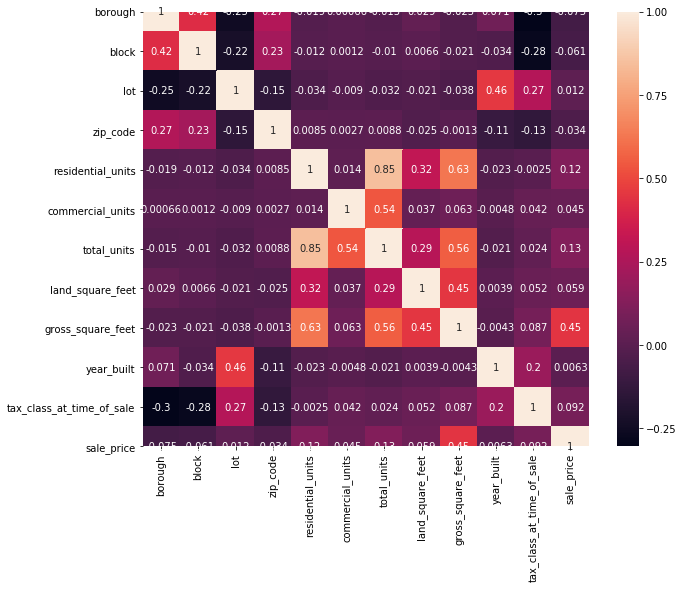

In [4]:
# Heatmap of correlations
plt.figure(figsize = (10,8))
corr = df_price.corr()
sns.heatmap(corr, annot = True)

#### Code to possibly slice dataset according to price thresholds
#df_sliced = df_price["sale_price"].copy()
#df_sliced_list = [x for x in df_sliced.tolist() if 100000 < x < 10000000]
#sns.distplot(df_sliced_list)

[100.0, 100.0, 100.0, 99.03, 100.0, 100.0, 99.03, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 92.32, 100.0, 100.0, 100.0, 100.0]


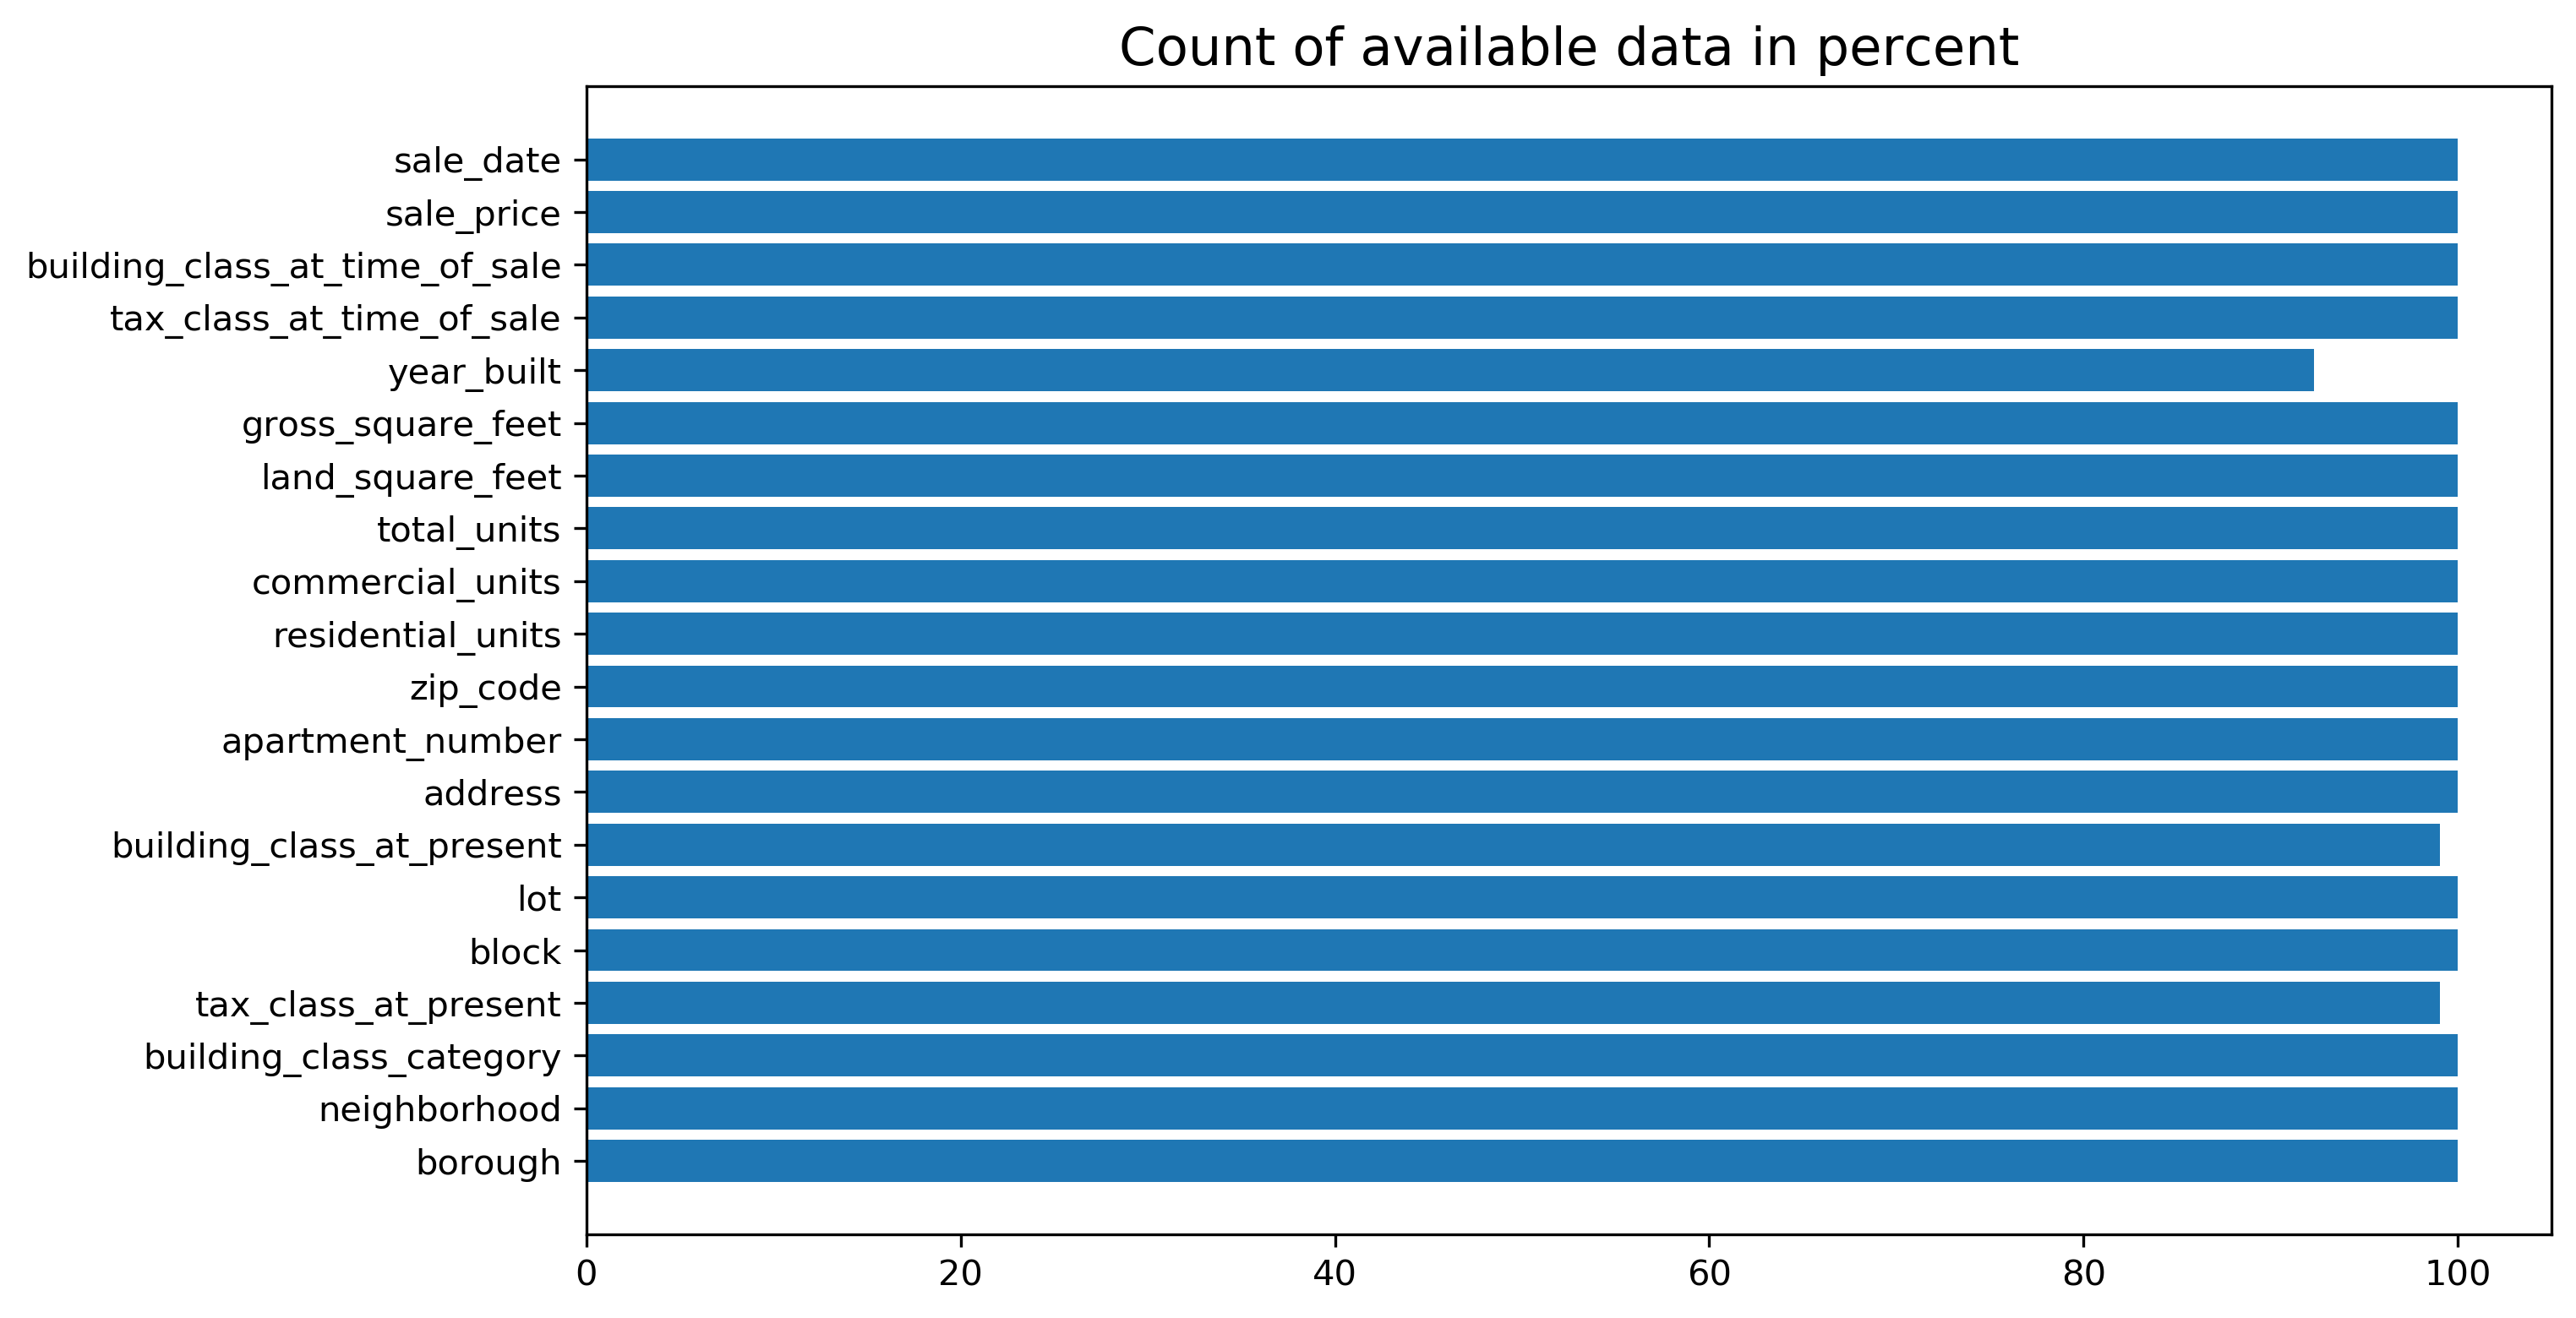

In [5]:
# Barplot of available values
gess = df_price.copy()
count = []
for var in gess.columns:
    length = gess[var].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(gess), 2)
print(count_pct.tolist())

plt.figure(figsize=(10,6), dpi = 300)
plt.barh(gess.columns, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

### List of Boroughs and Neighborhoods

In [6]:
df_price.columns.values
# open NYC_house_price
mylist = df_price['neighborhood'].tolist()
mylist = list(dict.fromkeys(mylist))
print(len(mylist))

254


## Data cleasing of NYC car accidents dataset

In [7]:
df_crash = cleaner.crash_cleaner(crashes)
df_crash

,index,accident_date,accident_time,borough,latitude,longitude,location,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,contributing_factor_vehicle_1,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,20000,2017-12-11,20:00,QUEENS,40.788548,-73.782040,"{'type': 'Point', 'coordinates': [-73.78204, 4...",0.0,0.0,0,...,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
1,20001,2017-11-28,9:00,NaN,40.776450,-73.901670,"{'type': 'Point', 'coordinates': [-73.90167, 4...",0.0,0.0,0,...,Traffic Control Disregarded,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,PICK-UP TRUCK,NaN,NaN,NaN
2,20002,2017-11-25,13:50,NaN,40.836290,-73.949240,"{'type': 'Point', 'coordinates': [-73.94924, 4...",0.0,0.0,0,...,Unsafe Lane Changing,Other Vehicular,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
3,20003,2017-12-02,18:15,NaN,40.637745,-74.076030,"{'type': 'Point', 'coordinates': [-74.07603, 4...",0.0,0.0,0,...,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
4,20004,2017-12-13,15:03,STATEN ISLAND,40.567060,-74.113205,"{'type': 'Point', 'coordinates': [-74.113205, ...",0.0,0.0,0,...,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204903,733708,2017-01-06,20:10,MANHATTAN,40.777874,-73.951750,"{'type': 'Point', 'coordinates': [-73.95175, 4...",0.0,0.0,0,...,Unspecified,NaN,NaN,NaN,NaN,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
204904,733709,2017-01-05,15:48,NaN,40.626034,-73.983270,"{'type': 'Point', 'coordinates': [-73.98327, 4...",0.0,0.0,0,...,Passing or Lane Usage Improper,Unspecified,NaN,NaN,NaN,MOTORCYCLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
204905,733713,2017-01-02,18:00,MANHATTAN,40.711746,-74.006996,"{'type': 'Point', 'coordinates': [-74.006996, ...",0.0,0.0,0,...,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,TAXI,PASSENGER VEHICLE,NaN,NaN,NaN
204906,733717,2017-01-07,5:30,NaN,40.764053,-73.992250,"{'type': 'Point', 'coordinates': [-73.99225, 4...",0.0,0.0,0,...,Turning Improperly,Unspecified,NaN,NaN,NaN,TAXI,TAXI,NaN,NaN,NaN


## Data cleasing of NYC Census and Blocks datasets

The "census" dataframe required only a little effort in cleasing operations, as shown through the chunck below, which output is $1.673 \% $
```python
print("Missing values: ",  df_blocks.isnull().sum().sum() , " | Perc of total: ",
      round(100*df_blocks.isnull().sum().sum() / (df_blocks.shape[0]*df_blocks.shape[1]), 3))
```
So, we decided to all drop the rows that presented NaN values, since they represent only a small share of the total (72 over 2167. i.e. $3.32 \% $). <br><br> With the same formula we noticed that the dataframe with all the coordinates is completely full.

## Data cleasing of Airbnbs of NYC dataset

With the same formula used before we noticed that also Airbnb dataset is characterized by a very low rate of empty cells, that is  $2.741 \% $.

```python
total = df1.isnull().sum().sort_values(ascending = False)
percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending = False)

missing_data = pd.concat([total, percent], axis = 1, keys = ['NAs', 'Percent']) # df with columns, nan values and %
plt.plot( missing_data['Percent'] )
missing_data.drop(missing_data[missing_data.Percent < 0.2].index, inplace = True)
```
After a further evaluation of the columns, we assessed that only ```"reviews_per_month"``` and ```"last_review"``` had more than more than 20% of the whole column filled with NaN values. So, we dropped those two columns and used ```.dropna()``` to delete other few rows with any NaN values.

In [8]:
df_airbnb = cleaner.airbnb_cleaner(airbnb)
df_airbnb.shape

(48486, 14)

## First try of ML Prediction

Steps to follow:
1. Descriptive analysis on the Data – 50% time
2. Data treatment (Missing value and outlier fixing) – 40% time
3. Data Modelling – 4% time
4. Estimation of performance – 6% time


STEP 1:
1. Identify ID, Input (columns of df_price) and Target (house price) features
2. Identify categorical and numerical features
3. Identify columns with missing values (already done)

In [ ]:
price_train = df_price.copy()
price_train = price_train.loc[0:500]

In [ ]:
df_census.iloc[1]

In [ ]:
price_train.dtypes

In [ ]:
r = np.corrcoef(price_train["total_units"],
                price_train["sale_price"])
r

In [ ]:
plt.scatter(price_train["total_units"],
                price_train["sale_price"])

In [ ]:
print( len([val for val in df_price["sale_price"] if val < 5000]) )

In [ ]:
len(np.arange(2000000, 200000000, 5000))

In [ ]:
x_var = np.arange(2000000, 200000000, 5000)
y_var = np.array( [len( [val for val in df_price["sale_price"] if val < x] ) for x in x_var] )
#z_soglia = [1650 for x in range(len(x_var))] # visual check for interception with y_var

plt.figure(figsize=(18,7))
plt.title("Andamento del numero di righe rispetto alla soglia fissata (x < soglia)")
plt.axvline(x = 2000000, color = "red", linewidth = 2)
#plt.plot(y_var, linewidth = 5, color = "#A4063E")
plt.scatter(x_var, y_var)
#plt.plot(y_var, linewidth = 5, color = "#A4063E")
#plt.plot(z_soglia, linewidth = 2, color = "blue")

In [ ]:
price_over_2M = [x for x in df_price["sale_price"].tolist() if 2000000 < x < 200000000]
price_over_2M[0]

In [ ]:
sns.distplot(price_over_2M, axlabel = "sale_price")

In [ ]:
sns.kdeplot([x for x in df_price["sale_price"].tolist() if 10000 < x < 2000000])
sns.kdeplot([x for x in df_price["sale_price"].tolist() if 20000 < x < 2000000])
sns.kdeplot([x for x in df_price["sale_price"].tolist() if 50000 < x < 2000000])
#sns.kdeplot([x for x in df_price["sale_price"].tolist() if 1000000 < x < 2000000])

In [ ]:
sns.distplot([x for x in df_price["sale_price"].tolist() if 10000 < x < 2000000], axlabel = "sale_price")

In [ ]:
max(df_price["sale_price"])

In [ ]:
asse_x = range(69607)
asse_y = sorted(df_price["sale_price"])
plt.scatter(asse_x, asse_y)

In [ ]:
list_price = df_price['neighborhood'].tolist()
list_price = list(dict.fromkeys(list_price))
list_price  = [x.lower() for x in list_price]

list_census = df_census["County"].tolist()
list_census = list(dict.fromkeys(list_census))

list_df1 = df1["neighbourhood"].tolist()
list_df1 = list(dict.fromkeys(list_df1))
list_df1  = [x.lower() for x in list_df1]

In [ ]:
print(list_price)

In [ ]:
print(list_df1)

In [ ]:
list_census_state = df_blocks["State"].tolist()
list_census_state = list(dict.fromkeys(list_census_state))

In [ ]:
list_census_state

In [ ]:
print( len([x for x in list_price if x in list_df1]) )